In [1]:
import keras
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import os
import seaborn as sns
import sys
from datetime import datetime

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils.plotting import plot_confusion_matrix
from model.trainer import Cifar10Trainer
from data.processing import standardize_data
from model.evaluate import evaluate_model
from utils.plotting import plot_confusion_matrix, plot_multi_auc

%matplotlib inline

Using TensorFlow backend.
/Users/chhuang/miniconda3/envs/cifar10/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/chhuang/Projects/cifar10/model/evaluate.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/chhuang/miniconda3/envs/cifar10/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/chhuang/miniconda3/envs/cifar10/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/chhuang/miniconda3/envs/cifar10/lib/python3.6/site-packages/ipykernel_launcher.py", li

## Load Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
label_list = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
label_decoder = {i: label for i, label in enumerate(label_list)}
print(f"the training dataset image dimensions are: {x_train.shape}")
print(f"the training dataset label dimensions are: {y_train.shape}")
print(label_decoder)

the training dataset image dimensions are: (50000, 32, 32, 3)
the training dataset label dimensions are: (50000, 1)
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [3]:
label_collections = {}
for i in range(10):
    indices, _ = np.where(y_train == i)
    label_collections[i] = indices
    print(f"number of {label_decoder[i]} examples: {indices.size}")

number of airplane examples: 5000
number of automobile examples: 5000
number of bird examples: 5000
number of cat examples: 5000
number of deer examples: 5000
number of dog examples: 5000
number of frog examples: 5000
number of horse examples: 5000
number of ship examples: 5000
number of truck examples: 5000


## Precision / Recall

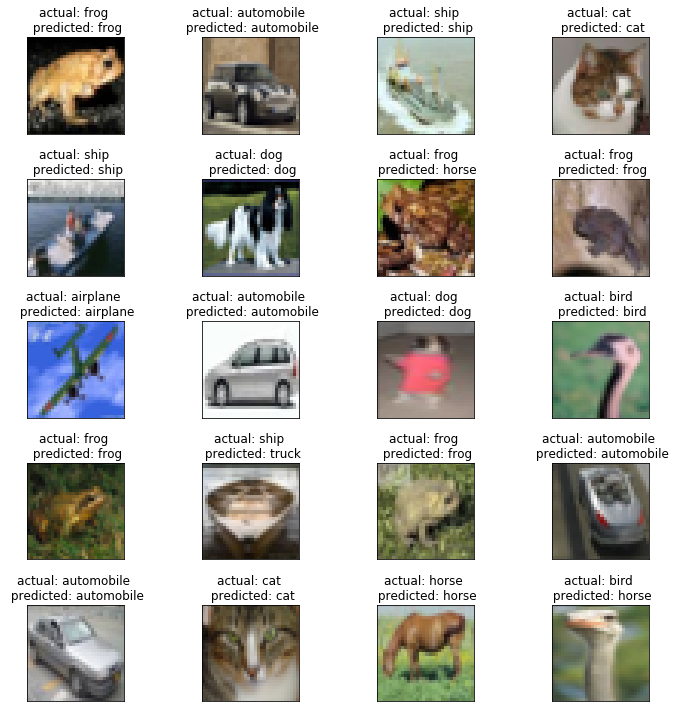

In [4]:
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 5
proba = 0.8
true_labels = []
preds = []
for i in range(1, columns*rows +1):
    img_id = np.random.choice(x_train.shape[0])
    img = x_train[img_id]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.xticks([], [])
    plt.yticks([], [])
    true_labels.append(y_train[img_id].item())
    if np.random.rand(1) > proba:
        preds.append(np.random.choice([x for x in range(10) if x != true_labels[i-1]]))
    else:
        preds.append(true_labels[i-1])
    plt.title(f"actual: {label_decoder[true_labels[i-1]]} \n predicted: {label_decoder[preds[i-1]]}")
fig.tight_layout()
plt.show()

## Confusion Matrix

precision score of the model is 0.85
Confusion matrix, without normalization


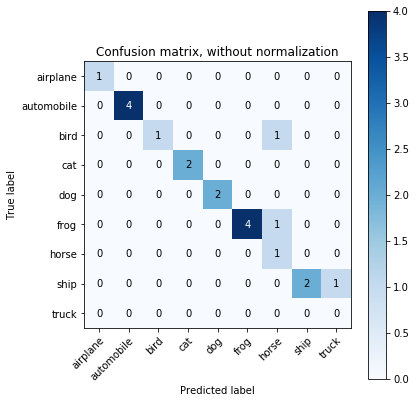

(<matplotlib.axes._subplots.AxesSubplot at 0x12b7df358>,
 array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 4, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 2, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 2, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 4, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 2, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]]))

In [5]:
precision = precision_score(true_labels, preds, average="micro")
print(f"precision score of the model is {precision}")
plot_confusion_matrix(true_labels, preds, classes=label_list,
                      title='Confusion matrix, without normalization')

## RGB Image

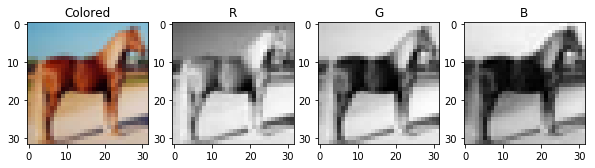

In [6]:
image = x_train[43]
fig = plt.figure(figsize=(10, 4))
fig.add_subplot(1, 4, 1)
plt.imshow(image)
plt.title("Colored")
titles = ["R", "G", "B"]
for i in range(3):
    fig.add_subplot(1, 4, i + 2)
    plt.imshow(image[:,:,i], cmap='gray')
    plt.title(titles[i])

## Label one-hot-encoding

In [7]:
print(y_train[:10, 0])
print([label_decoder[x] for x in y_train[:10, 0]])

[6 9 9 4 1 1 2 7 8 3]
['frog', 'truck', 'truck', 'deer', 'automobile', 'automobile', 'bird', 'horse', 'ship', 'cat']


In [8]:
y_train_one_hot = keras.utils.to_categorical(y_train, num_classes=np.unique(y_train).size)
print(y_train_one_hot[:10,:])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


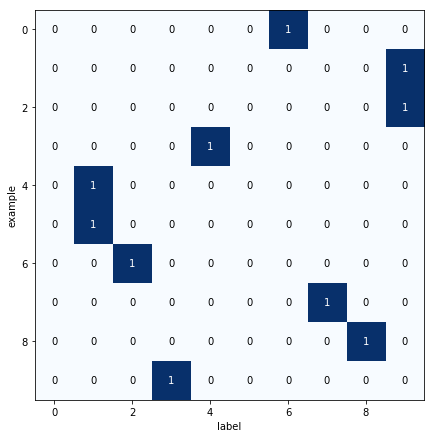

In [9]:
one_hot_plot = y_train_one_hot[:10,:].astype(int)
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(one_hot_plot, interpolation='nearest', cmap="Blues")
fmt = 'd'
thresh = np.max(one_hot_plot) / 2
for i in range(one_hot_plot.shape[0]):
    for j in range(one_hot_plot.shape[1]):
        ax.text(j, i, format(one_hot_plot[i, j], fmt),
                ha="center", va="center",
                color="white" if one_hot_plot[i, j] > thresh else "black")
fig.tight_layout()
plt.xlabel("label")
plt.ylabel("example")
plt.show()

## Data Preprocessing

Original pixel value distribution

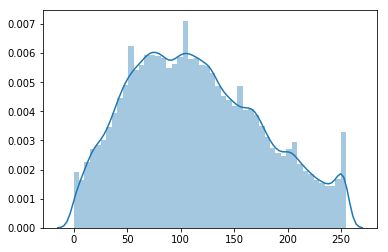

In [10]:
test_images = x_train[:100].copy()
sns.distplot(test_images.ravel(), bins=50)
plt.show()

Mean subtraction

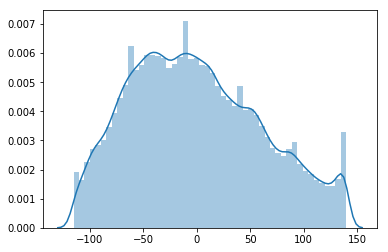

In [11]:
test_images = test_images.astype(float)
test_images -= np.mean(test_images)
sns.distplot(test_images.ravel(), bins=50)
plt.show()

Standardization

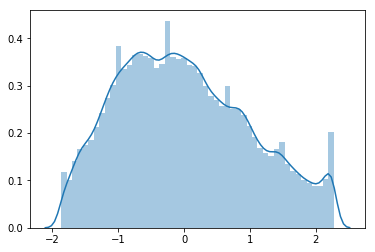

In [12]:
test_images /= np.std(test_images)
sns.distplot(test_images.ravel(), bins=50)
plt.show()

In [13]:
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)
x_train = standardize_data(x_train)
x_test = standardize_data(x_test)

## Model Training

In [14]:
artifact_base = "/tmp/artifact/cifar10"

hyperparameters = {
  "learning_rate": 0.001,
  "batch_normalization": True,
  "weight_decay": 1e-4,
  "base_filters": 32,
  "batch_size": 64,
  "fc_size": 128,
  "dropout": 0.2,
  "lr_decay": 1e-6,
  "rotation_angle": 15,
  "width_shift_range": 0.1, 
  "height_shift_range": 0.1,
  "shear_range": 0.1,
  "zoom_range": 0.1,
  "horizontal_flip": True,
  "early_stopping_patience": 15,
  "reduce_lr_patience": 6,
  "reduce_lr_factor": 0.3,
  "activation": "relu",
  "classifier_activation": "softmax",
  "loss": "categorical_crossentropy"
}
job_name = "training_test_"
timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
artifact_directory = os.path.join(artifact_base, job_name+timestamp)

In [15]:
trainer = Cifar10Trainer(
    model_name="convnet6",
    hyperparameters=hyperparameters,
    artifact_directory=artifact_directory,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
__________

In [16]:
# trainer.train()

## Evaluate model

In [17]:
model_artifact = "../artifacts/weights.92-0.449348.hdf5"

Confusion matrix, without normalization


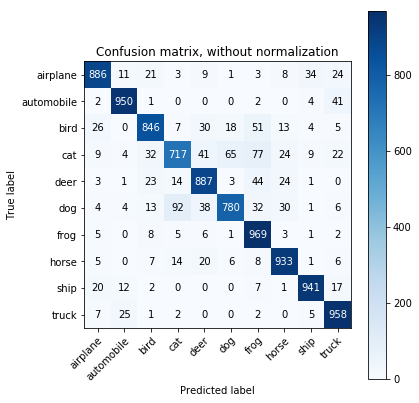

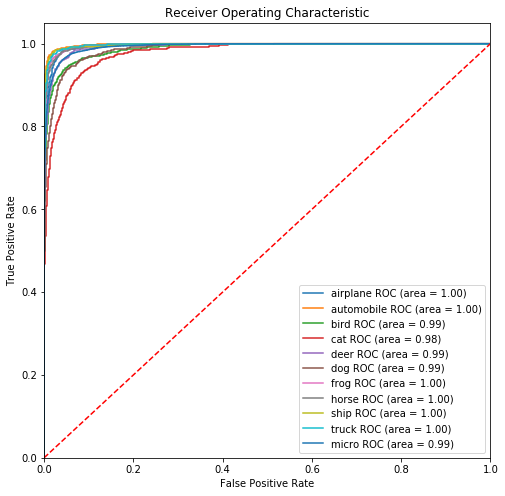

Accuracy: 0.8867


In [18]:
fpr, tpr, roc_auc, cm = evaluate_model(model_artifact, x_test, y_test, label_list)